# Inference of parameters (SIR model)
In this notebook, we consider the SIR model with symptomatically and asymptomatically infected. We are trying to infer the parameters of the model 

* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals), and
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals) 

when given the full data (of classes S, Ia, Is) from a generated trajectory.


In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

## 1) Generate a trajectory
We generate a test trajectory on a population with two ages groups.

In [3]:
M = 2                # the population has two age groups
N = 5e4              # and this is the total population

# correct params
beta  = 0.02         # infection rate
gIa   = 1./7         # recovery rate of asymptomatic infectives
gIs   = 1./7         # recovery rate of asymptomatic infectives
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
Ia0 = np.array([10, 10])  # each age group has asymptomatic infectives
Is0 = np.array([10, 10])  # and also symptomatic infectives
R0  = np.array([0, 0])    # there are no recovered individuals initially
S0  = Ni - (Ia0 + Is0 + R0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
true_parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SIR(parameters, M, Ni)
data = sto_model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('SIR_sto_traj.npy', data_array)

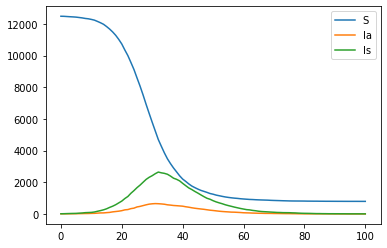

In [4]:
plt.plot(data_array[:, 0], label='S')
plt.plot(data_array[:, M], label='Ia')
plt.plot(data_array[:, 2*M], label='Is')
plt.legend()
plt.show()

## 2) Inference
We take the first $50$ data points of the trajectories and use it to infer the parameters of the model.

In [5]:
# load the data and rescale to intensive variables 
Tf = 50 # truncate to only getting the first few datapoints 
Nf = Tf+1

x = np.load('SIR_sto_traj.npy').astype('float')
x = (x/N)[:Nf]
steps = 101 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-2126.775473654352
0.3196389675140381


In [6]:
# Define the prior (Gamma prior around guess of parameter with defined std. deviation)
beta_g = 0.1
beta_std = 0.1

gIa_g = 0.14
gIa_std = 0.05

gIs_g = 0.2
gIs_std = 0.1

alpha_g = 0.3
alpha_std = 0.2

fsa_g = 0.8
fsa_std = 0.05

# compute -log_p for the initial guess 
parameters = {'alpha':alpha_g, 'beta':beta_g, 'gIa':gIa_g, 'gIs':gIs_g, 'fsa':fsa_g}
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
print(logp) 

49792.70651576962


In [24]:
# inference  
eps = 1e-4   # step size for finite difference computation of Hessian
ftol = 1e-6  # Stopping criterion for minimisation (realtive change in function value)
keys = ['alpha', 'beta', 'gIa', 'gIs', 'fsa']
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, fsa_g])  # Initial value (and expected value of priors)
bounds = np.array([(eps, 0.8), (eps, 0.2), (eps, 0.6), (eps, 0.6), (0.7, 0.9)])  # give some bounds
stds = np.array([alpha_std, beta_std , gIa_std, gIs_std, fsa_std])
start_time = time.time() 
params = estimator.infer_parameters(keys, guess, stds, bounds, x, Tf, Nf, contactMatrix, global_max_iter=50,
                             local_max_iter=200, eps=eps, global_ftol_factor=1e2, ftol=ftol, verbose=True)
end_time = time.time()

print(params) # best guess 
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 5 (seed=313959, Mon May 11 16:16:45 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 6.186422795900027e+03 1.0e+00 9.77e-01  5e-02  2e-01 0:04.5
    2     32 -3.999812822803517e+02 1.4e+00 8.88e-01  4e-02  2e-01 0:08.2
    3     48 8.129788520187211e+03 1.6e+00 8.23e-01  4e-02  2e-01 0:12.1
    5     80 1.845094948138183e+03 2.0e+00 7.37e-01  3e-02  1e-01 0:18.4
    7    112 3.366793503165458e+03 3.4e+00 8.08e-01  3e-02  1e-01 0:25.0
    9    144 -3.148575911896441e+02 5.5e+00 8.87e-01  2e-02  2e-01 0:31.2
   12    192 -1.206869441093010e+03 9.6e+00 7.61e-01  2e-02  1e-01 0:39.6
   15    240 -1.799113127540840e+03 1.2e+01 5.49e-01  7e-03  8e-02 0:48.0
   16    256 -1.942042221563193e+03 1.5e+01 5.22e-01  6e-03  7e-02 0:57.3
   19    304 -1.947141141538491e+03 2.2e+01 4.69e-01  4e-03  6e-02 1:06.6
   23    368 -2.025397771595996e+03 3.0e+01 4.75e-01  3e-03  5e-02 1:

In [25]:
# compute log_p for best estimate 
start_time = time.time() 
new_parameters = estimator.fill_params_dict(keys, params)
logp = estimator.obtain_minus_log_p(new_parameters, x, Tf, Nf, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-2127.269862932254
0.30911803245544434


In [26]:
print("True parameters:")
print(true_parameters)

print("\nInferred parameters:")
print(new_parameters)

True parameters:
{'alpha': 0.2, 'beta': 0.02, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'fsa': 0.8}

Inferred parameters:
{'alpha': 0.20686094878641748, 'beta': 0.021359764813968812, 'gIa': 0.1492680240774802, 'gIs': 0.1415946244435152, 'fsa': 0.7342580938414488}


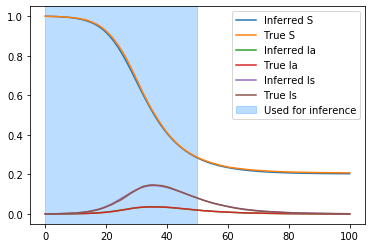

In [32]:
x = np.load('SIR_sto_traj.npy').astype('float')/N 
Nf = x.shape[0]
Tf = Nf-1

det_model = pyross.deterministic.SIR(new_parameters, int(M), fi)
x_det = estimator.integrate(x[0], 0, Tf, Nf, det_model, contactMatrix)
plt.plot(np.sum(x_det[:, :M], axis=1), label='Inferred S')
plt.plot(np.sum(x[:, :M], axis=1), label='True S')
plt.plot(np.sum(x_det[:, M:2*M], axis=1), label='Inferred Ia')
plt.plot(np.sum(x[:, M:2*M], axis=1), label='True Ia')
plt.plot(np.sum(x_det[:, 2*M:3*M], axis=1), label='Inferred Is')
plt.plot(np.sum(x[:, 2*M:3*M], axis=1), label='True Is')
plt.axvspan(0, 50, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.legend()
plt.show() 

In [28]:
hess = estimator.compute_hessian(keys, params, guess, stds, x, Tf, Nf, contactMatrix)

In [29]:
np.linalg.inv(hess) # the covariance that can be inputed into the forecast module for forecasting 

array([[ 4.44447210e-05,  4.72514744e-09,  3.31398870e-05,
        -8.34485871e-06, -2.64273910e-07],
       [ 4.72514744e-09, -1.79813714e-07,  5.78631888e-09,
         4.83454652e-10,  8.00067659e-06],
       [ 3.31398870e-05,  5.78631888e-09,  3.10836651e-05,
        -6.94419996e-06, -2.86625593e-07],
       [-8.34485871e-06,  4.83454652e-10, -6.94419996e-06,
         2.59053179e-06,  8.63106298e-09],
       [-2.64273910e-07,  8.00067659e-06, -2.86625593e-07,
         8.63106298e-09, -3.28860526e-04]])